In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Linearity Correction

Example notebook to generate a non-linearity correction function. The general idea is to use sample-up-the-ramp data to determine a flux-dependent correction factor that linearizes the ramps. The final product is a set of polynomial coefficents that represent the correction function. In principle, this can be accomplished independently for every pixel in the array, but for simplicity, this notebook determines a single correction function that is used for every light-sensitive pixel (e.g., excludes reference pixels).

In [2]:
# Reference pixel correction modules and functions
import ref_pixels
from ref_pixels import robust
from ref_pixels import reffix_hxrg, get_fits_data
from ref_pixels import jl_poly_fit, jl_poly

from ref_pixels.utils import find_sat, cube_fit, hist_indices

# Astropy FITS
from astropy.io import fits

# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
def gen_average_ramp(allfiles, det, bias=None, deg=2, **kwargs):
    """ Crete an averaged data cube from all FITS cubes """
    
    nfiles = len(allfiles)

    # Time array
    tarr = det.times_group_avg
    
    data_mean = np.zeros([nz, ny, nx])
    for fname in tqdm(allfiles):
        # Read in data
        data = get_fits_data(fname, bias=bias, reffix=True, **kwargs)
        # Perform fit to 50% saturation
        cf = cube_fit(tarr, data, sat_frac=0.5, deg=deg, ref_info=det.ref_info)
        # Subtract bias offset image
        data -= cf[0]
        
        data_mean += data

    # Take average
    data_mean /= nfiles
    
    return data_mean

In [4]:
def gen_lincorr(data_cube, det, return_binvals=False):
    """ Create a linearity correction function. 
    
    This produces a set of polynomial coefficients that are used to generate
    a correction factor based on measured flux values (after bias subtration
    and reference pixel correction).
    
    The assumes all pixels have the same non-linearity function. While not
    necessarily true, creating independent corrections for each pixel can be
    rather challenging. The method showcased here produces corrected data that 
    is >99% linear.
    """
    
    # Time array
    tarr = det.times_group_avg
    
    # Active and reference pixel masks
    mask_act = det.mask_act
    
    # Get saturation values for each pixel
    sat_vals = find_sat(data_cube, ref_info=det.ref_info)
    
    # Fit linear regime of all pixels to get coefficients
    # cf_all = cube_fit(tarr, data_cube, sat_vals=sat_vals, sat_frac=0.25, fit_zero=True, deg=1)
    cf_all = cube_fit(tarr[1:], data_cube[1:], sat_vals=sat_vals, sat_frac=0.5, fit_zero=True, deg=2)
    
    # Generate a ramp of ideal linear data from fit coefficients
    data_fit = jl_poly(tarr, cf_all[0:2])
    
    # Calculate correction for every data sample
    ratio = data_fit / data_cube
    
    # Create a ramp mask of pixels below saturation levels
    mask_good = data_cube < 0.99*sat_vals
    # Combine with active pixel mask
    mask = mask_good & mask_act

    # All data flattened into a single array
    xv = data_cube[mask].flatten()
    yv = ratio[mask].flatten()
    
    # Bin data
    bsize = 1000
    bins = np.arange(xv.min(), xv.max()+bsize, bsize)
    ig, vg, cv = hist_indices(xv, bins=bins, return_more=True)
    
    # Grab indices that have non-negative data 
    well_max_fit = np.median(sat_vals)
    nvals = np.array([len(i) for i in ig])
    imask = (nvals>0) & (cv>=0) & (cv<well_max_fit)
    ig_nozero = np.array(ig)[imask]
    
    # Take the median of data in each valid bin
    xmed = np.array([np.median(xv[i]) for i in ig_nozero])
    ymed = np.array([np.median(yv[i]) for i in ig_nozero])
    
    # Add data point for ratio of 1 at x=0
    ifit = (ymed>=1)
    xfit = np.concatenate(([0],xmed[ifit]))
    yfit = np.concatenate(([1],ymed[ifit]))
    
    cf = jl_poly_fit(xfit, yfit, deg=7, robust_fit=True)
    
    if return_binvals:
        return cf, xmed, ymed
    else:
        return cf


## Linearity FITS Cubes

Paths to linearity and superbias data.

In [5]:
import os

flat_dir = '/Users/jarron/SHARK-NIR/20200215_Lin/Lin_250kHz/'
flat_files = np.array([flat_dir + f for f in os.listdir(flat_dir) if f.endswith('.fits')])
flat_files.sort()

In [6]:
# Read in superbias image
bias_path = '/Users/jarron/SHARK-NIR/20200220_Dark/SHARK-NIR_250Hz_superbias_example.fits'
superbias = get_fits_data(bias_path)

## Detector timing

Define a detector timing object that houses all the necessary information concerning the pixel and frame clocking, detector size and output channels, etc.

In [7]:
# Get shape information for input file
hdul = fits.open(flat_files[0])
nz, ny, nx = hdul[0].data.shape
hdul.close()

# Detector timing info
if nx<2048 and ny<2048:
    wind_mode = 'WINDOW'
elif ny<2048:
    wind_mode = 'STRIPE'
else:
    wind_mode = 'FULL'
    
det = ref_pixels.detops.det_timing(mode='SHARK_250', wind_mode=wind_mode, xpix=nx, ypix=ny, ngroup=nz)

[    refpix:INFO] RAPID readout mode selected.
[    refpix:INFO] Setting nf=1, nd1=0, nd2=0, nd3=0.


In [8]:
# Double check basic frame size and setup information
print(det.to_dict())

{'wind_mode': 'FULL', 'nout': 4, 'xpix': 2048, 'ypix': 2048, 'x0': 0, 'y0': 0}


In [9]:
# Check timing information makes sense
det.times_to_dict()

{'t_frame': 4.278316,
 't_group': 4.278316,
 't_int': 106.9579,
 't_exp': 106.9579,
 't_acq': 111.238304,
 't_int_tot1': 111.236216,
 't_int_tot2': 0.0}

In [10]:
# Time array
tarr = det.times_group_avg
print(tarr)

[  4.278316   8.556632  12.834948  17.113264  21.39158   25.669896
  29.948212  34.226528  38.504844  42.78316   47.061476  51.339792
  55.618108  59.896424  64.17474   68.453056  72.731372  77.009688
  81.288004  85.56632   89.844636  94.122952  98.401268 102.679584
 106.9579  ]


In [11]:
# Active and reference pixel masks
mask_ref = det.mask_ref
mask_act = ~mask_ref

## Calculate average ramp

Call the function that will perform bias subtraction and reference pixel correction in order to cacluate the final linearity calibration function.

In [12]:
# Keyword arguments to pass to reference pixel correction before slope fitting
kw_refpix = {
    'nchans': det.nout, 'altcol': True, 'in_place': True,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False
}

data_mean = gen_average_ramp(flat_files, det, bias=superbias, **kw_refpix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# Generate the linearity correction polynomial coefficients
cf_lincorr, vals_dn, ratio = gen_lincorr(data_mean, det, return_binvals=True)

Coefficients `cf_lincorr` can then be used to generate the correction factor directly from flux values (after bias subtration and reference pixel correction):

``` python
# Assume vals are an array of uncorrected values
corr_fact = jl_poly(vals, cf_lincorr)
vals_corr = vals * corr_fact
```

In [14]:
# Create correction for average of pixel data
# Don't correct reference pixels
vals = np.median(data_mean[:,mask_act], axis=1) 
corr_fact = jl_poly(vals, cf_lincorr)
vals_corr = vals * corr_fact

# Check the correction compared to linear fit
ifit = vals_corr < 40000
cf = jl_poly_fit(tarr[ifit],vals_corr[ifit])
frac_diff = (vals_corr - jl_poly(tarr, cf)) / vals_corr

In the above cell, we created a median ramp of all active pixels, then perform the correction on those values. However, we could instead flip the order around such that we first perform the linearity correction on the entire cube, then take the median of the corrected ramp:

``` python
mask_ref = det.mask_ref
mask_act = det.mask_act 
corr_fact_all = jl_poly(data_mean[:, mask_act].flatten(), cf_lincorr)
# Create corrected cube
data_mean_corr = np.zeros_like(data_mean)
data_mean_corr[:, mask_act] = data_mean[:, mask_act] * corr_fact_all.reshape([data_mean.shape[0],-1])
data_mean_corr[:, mask_ref] = data_mean[:, mask_ref]
# Take median of all active pixels
data_med = np.median(data_mean_corr[:,mask_act], axis=1)
# Delete correction factor array
del corr_fact_all 
```

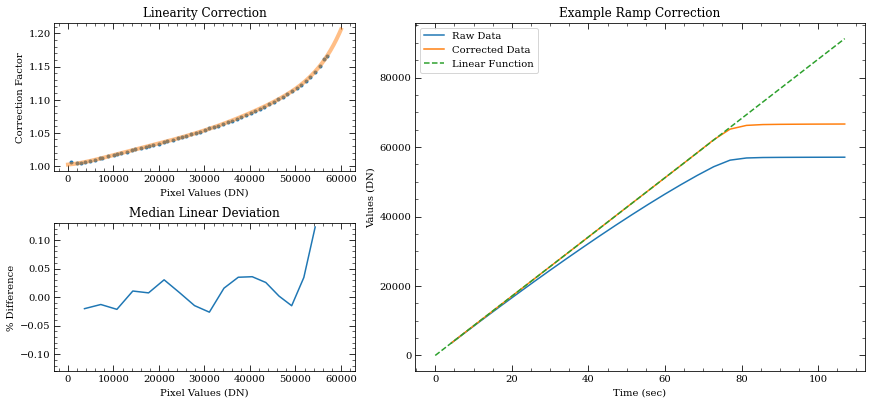

In [15]:
# Plot everything
layout = """
    AACCC
    BBCCC
    """ 
fig = plt.figure(constrained_layout=True, figsize=(12,5.5))
ax_dict = fig.subplot_mosaic(layout)

# Linearity correction factor
ax = ax_dict['A']
ax.plot(vals_dn, ratio, ls='none', marker='.')
xvals = np.linspace(0, 60000, 1000)
ax.plot(xvals, jl_poly(xvals,cf_lincorr), lw=4, alpha=0.5)
ax.set_title('Linearity Correction')
ax.set_xlabel('Pixel Values (DN)')
ax.set_ylabel('Correction Factor')

# 
ax = ax_dict['B']
iplot = vals<55000
ax.plot(vals[iplot], 100*frac_diff[iplot])
ax.set_ylim(np.array([-1,1])*np.max(np.abs(ax.get_ylim())))
ax.set_xlim(ax_dict['A'].get_xlim())
ax.set_title('Median Linear Deviation')
ax.set_xlabel('Pixel Values (DN)')
ax.set_ylabel('% Difference')

ax = ax_dict['C']
ax.plot(tarr, vals, label='Raw Data')
ax.plot(tarr, vals_corr, label='Corrected Data')
ifit = vals_corr < 60000
cf = jl_poly_fit(tarr[ifit],vals_corr[ifit])
tvals = np.linspace(0,tarr.max(),100)
ax.plot(tvals, jl_poly(tvals, cf), label='Linear Function', ls='--')
ax.set_title('Example Ramp Correction')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Values (DN)')
ax.legend();

In [16]:
# Save linearity coefficients file
outdir = '/Users/jarron/SHARK-NIR/20200215_Lin/'
file_out = 'SHARK-NIR_250Hz_lincorr.npy'

np.save(outdir + file_out, cf_lincorr)

In [17]:
corr_fact = np.zeros_like(data_mean)
for i, cf in enumerate(cf_lincorr):
    corr_fact += cf * data_mean**i
        
# Make sure reference pixels are excluded
corr_fact[:, mask_ref] = 1
data_corr = data_mean * corr_fact

# Get saturation values
sat_vals = find_sat(data_corr, ref_info=det.ref_info)
del corr_fact, data_corr

In [19]:
# Save saturation values to file
outdir = '/Users/jarron/SHARK-NIR/20200215_Lin/'
file_out = 'SHARK-NIR_250Hz_lincorr_satvals.fits'

hdu = fits.PrimaryHDU(sat_vals)
hdu.writeto(outdir + file_out, overwrite=True)